<a href="https://colab.research.google.com/github/Antonio-Belo/MVP_Sprint_II/blob/main/MVP_II_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sprint II A - MACHINE LEARNING & ANALYTICS
Data Science & Analytics - PUC Rio

Antonio Carlos Avallone Belo


## **Método Clássico para um problema de Classificação - Detecção de Fraude**

## **Definição do Problema**

**Objetivo:** O modelo irá identicar se uma transação Bancária é Fraudulenta

**Descrição do problema:**
Há uma falta de conjuntos de dados publicamente disponíveis nos serviços financeiros e especialmente no domínio emergente de transações de dinheiro móvel. Os conjuntos de dados financeiros são importantes para muitos pesquisadores e, em particular, para nós que realizamos pesquisas no domínio da detecção de fraudes. Parte do problema é a natureza intrinsecamente privada das transações financeiras, que não leva a conjuntos de dados publicamente disponíveis.

Os dados são sintéticos e gerados por uma simulador chamado PaySim como uma abordagem para tal problema. O PaySim usa dados agregados do conjunto de dados privados para gerar um conjunto de dados sintéticos que se assemelha à operação normal de transações e injeta comportamento malicioso para avaliar posteriormente o desempenho dos métodos de detecção de fraude.

Este conjunto de dados sintético é reduzido em 1/4 do conjunto de dados original e é criado apenas para o Kaggle.

Esta é uma amostra de 1 linha com explicação de cabeçalhos:

**Exemplo do Registro :**  1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

**Atributos  :**

**step** - mapeia uma unidade de tempo no mundo real. Neste caso, 1 passo é 1 hora de tempo. Total de etapas 744 (simulação de 30 dias).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount**  - valor da transação em moeda local.

**nameOrig** - cliente que iniciou a transação

**oldbalanceOrg** - saldo inicial antes da transação

**newbalanceOrig** - novo saldo após a transação.

**nameDest** - cliente que é o destinatário da transação

**oldbalanceDest** - destinatário do saldo inicial antes da transação. Observe que não há informações para clientes que começam com M (Comerciantes).

**newbalanceDest**- novo destinatário do saldo após a transação. Observe que não há informações para clientes que começam com M (Comerciantes).

**isFraud -** São as transações feitas pelos agentes fraudulentos dentro da simulação. Neste conjunto de dados específico, o comportamento fraudulento dos agentes visa lucrar tomando controle ou contas de clientes e tentando esvaziar os fundos transferindo para outra conta e depois sacando do sistema.

**isFlaggedFraud**  - O modelo de negócios visa controlar transferências massivas de uma conta para outra e sinaliza tentativas ilegais. Uma tentativa ilegal neste conjunto de dados é uma tentativa de transferir mais de 200.000 em uma única transação.

## **Preparação dos Dados**

A base é totalmente desbalanceada, pois existem poucas estâncias de fraude no dataframe  , sendo necessário fazer um oversampling  para balancear o modelo .
Para mostrar a existência deste balanceamento, foram executadas as etapas holdout duas vezes . Antes do balanceamento , foi usado apenas um modelo (LR) para a visualização do equilibrio e depois do balanceamento foi feito com todos possíveis e automatizadas pela pipeline.

Após a análise das execuções de 3 formas de Features Selection , devido a importância para a avaliação da fraude que apareceram nas correlações apresentadas no profile report do Pandas , só foram "dropados" os atributos sensíveis (Identificação do Cliente)

## Configurando o Ambiente

In [48]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

!pip install -U pandas-profiling   #  Para a utilização do Report para analisar melhor os dados


In [49]:
!pip install -U Imbalanced-learn   # Usado para Balancear os registros

In [50]:

#
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline

# análise
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay

#preparação da modelagem
from sklearn.model_selection import GridSearchCV # para otimização de hiperparâmetros
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import StratifiedKFold # variação do KFold que permite lidar melhor com datasets desbalanceados
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada


#adicionando a base para a construção do pipeline
from sklearn.pipeline import Pipeline

#avaliação dos resultados

from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo

#preparação dos dados
from sklearn.preprocessing import OneHotEncoder #One Hot Encoder - transformar instâncias categóricas em numéricas
from sklearn.preprocessing import StandardScaler #Normalização
from sklearn.preprocessing import MinMaxScaler #Padronização

#adicionando modelos que serão utilizados
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM
from sklearn.linear_model import LogisticRegression

#adicionando a base para a construção dos ensembles
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier # ExtraTrees, para a Importância de Atributos
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

#adicionando a base para a feature selection
from sklearn.feature_selection import SelectKBest # para a Seleção Univariada
from sklearn.feature_selection import f_classif # para o teste ANOVA da Seleção Univariada
from sklearn.feature_selection import RFE # para a Eliminação Recursiva de Atributos

from imblearn.over_sampling import SMOTE   # fazer o balanceamento




**Carga do Dataset**

In [51]:
url = 'https://raw.githubusercontent.com/Antonio-Belo/MVP_Sprint_II/main/fraud_dataset_example.csv' # teste completo 101.613 linhas
df = pd.read_csv(url, delimiter=',')
df = df.head(50000)                         # limitador de registros                                # tamanho de 50.000 linhas

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            50000 non-null  int64  
 1   type            50000 non-null  object 
 2   amount          50000 non-null  float64
 3   nameOrig        50000 non-null  object 
 4   oldbalanceOrg   50000 non-null  float64
 5   newbalanceOrig  50000 non-null  float64
 6   nameDest        50000 non-null  object 
 7   oldbalanceDest  50000 non-null  float64
 8   newbalanceDest  50000 non-null  float64
 9   isFraud         50000 non-null  int64  
 10  isFlaggedFraud  50000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 4.2+ MB


In [53]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [54]:
# Arrumando as colunas para melhorar a visualizacao
df = df[['isFraud',
       'isFlaggedFraud', 'step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest']]

# Criando o Dicionario das colunas
colunas = {
    'isFraud': 'fraude',
    'isFlaggedFraud':'alerta_fraude',
    'step':'tempo',
    'type':'forma',
    'amount':'valor',
    'nameOrig':'cli_origem',
    'oldbalanceOrg':'saldo_origem',
    'newbalanceOrig':'novo_saldo_origem',
    'nameDest':'cli_destino',
    'oldbalanceDest':'saldo_destino',
    'newbalanceDest':'novo_saldo_destino',
}
df = df.rename(columns = colunas)
df.head()


fraude  alerta_fraude  tempo     forma     valor   cli_origem  \
0       0              0      1   PAYMENT   9839.64  C1231006815   
1       0              0      1   PAYMENT   1864.28  C1666544295   
2       1              0      1  TRANSFER    181.00  C1305486145   
3       1              0      1  CASH_OUT    181.00   C840083671   
4       0              0      1   PAYMENT  11668.14  C2048537720   

   saldo_origem  novo_saldo_origem  cli_destino  saldo_destino  \
0      170136.0          160296.36  M1979787155            0.0   
1       21249.0           19384.72  M2044282225            0.0   
2         181.0               0.00   C553264065            0.0   
3         181.0               0.00    C38997010        21182.0   
4       41554.0           29885.86  M1230701703            0.0   

   novo_saldo_destino  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

* --------------------------------------------------------------------------------
Agrupamos o nosso Target  "Fralde" para saber verificar a quantidade existente no dataframe
--------------------------------------------------------------------------------


In [55]:
df.nunique()                   #  Quantidade de Valores diferentes em cada campo

fraude                    2
alerta_fraude             1
tempo                     9
forma                     5
valor                 49786
cli_origem            50000
saldo_origem          30572
novo_saldo_origem     24328
cli_destino           28499
saldo_destino         25369
novo_saldo_destino     9367
dtype: int64

In [56]:
df.groupby('fraude').tempo.count()  # Fazer o distinct do campo fralde  Existem 81 casos de Fraude

fraude
0    49900
1      100
Name: tempo, dtype: int64

Totalemente desbalanceada

Vamos remover os campos alerta_fraude, porque ela só tem um domínio (zeros)  e também vamos remover o cliente 1 e o  cliente 2 , pois não influenciará tanto no resultado e também, este campo não é recomendável que seja exibido.


In [57]:
df = df.drop(['cli_origem', 'cli_destino', 'alerta_fraude'], axis = 1)

In [58]:
df.isnull().values.any()                 # Verificar se tem algum Valor nulo nas colunas

False

O resultado é o esperado, não existe nenhum tipo nulo, portanto, não precisaremos fazer nenhum tratamento para esse tipo de dado.

In [59]:
X = df.drop('fraude', axis=1)            # Classe que ser nosso target será excluída de x  e criada em y
y = df['fraude']


In [60]:
 # pandas_profiling.ProfileReport(df)

**Aplicando o Encondig**

In [61]:
df = pd.get_dummies(data=df, columns=['forma'])
df.head()

fraude  tempo     valor  saldo_origem  novo_saldo_origem  saldo_destino  \
0       0      1   9839.64      170136.0          160296.36            0.0   
1       0      1   1864.28       21249.0           19384.72            0.0   
2       1      1    181.00         181.0               0.00            0.0   
3       1      1    181.00         181.0               0.00        21182.0   
4       0      1  11668.14       41554.0           29885.86            0.0   

   novo_saldo_destino  forma_CASH_IN  forma_CASH_OUT  forma_DEBIT  \
0                 0.0              0               0            0   
1                 0.0              0               0            0   
2                 0.0              0               0            0   
3                 0.0              0               1            0   
4                 0.0              0               0            0   

   forma_PAYMENT  forma_TRANSFER  
0              1               0  
1              1               0  
2              0               1  
3              0               0  
4              1               0

In [62]:
df.info()                  # verificando se os tipos perfeitos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fraude              50000 non-null  int64  
 1   tempo               50000 non-null  int64  
 2   valor               50000 non-null  float64
 3   saldo_origem        50000 non-null  float64
 4   novo_saldo_origem   50000 non-null  float64
 5   saldo_destino       50000 non-null  float64
 6   novo_saldo_destino  50000 non-null  float64
 7   forma_CASH_IN       50000 non-null  uint8  
 8   forma_CASH_OUT      50000 non-null  uint8  
 9   forma_DEBIT         50000 non-null  uint8  
 10  forma_PAYMENT       50000 non-null  uint8  
 11  forma_TRANSFER      50000 non-null  uint8  
dtypes: float64(5), int64(2), uint8(5)
memory usage: 2.9 MB


In [63]:
test_size = 0.25                         # tamanho do conjunto de teste
seed =  7                                # semente aleatória

# Separação em bases de treino e teste (holdout)

array = df.values
X = array[:,0:10]                        # atributos
y = array[:,00]                          # target
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = seed)


* **Features** **Selection**  

In [64]:
# SelectKBest

# Seleção de atributos com SelectKBest
best_var = SelectKBest(score_func=f_classif, k=4)

# Executa a função de pontuação em (X, y) e obtém os atributos selecionados
fit = best_var.fit(X, y)

# Reduz X para os atributos selecionados
features = fit.transform(X)

# Resultados
print('\nNúmero original de atributos:', X.shape[1])
print('\nNúmero reduzido de atributos:', features.shape[1])

# Exibe os atributos orginais
print("\nAtributos Originais:", df.columns[0:13])

# Exibe as pontuações de cada atributos e os 4 escolhidas (com as pontuações mais altas)
np.set_printoptions(precision=3) # 3 casas decimais
print("\nScores dos Atributos Originais:", fit.scores_)
print("\nAtributos Selecionados:", best_var.get_feature_names_out(input_features=df.columns[0:10]))


Número original de atributos: 10

Número reduzido de atributos: 4

Atributos Originais: Index(['fraude', 'tempo', 'valor', 'saldo_origem', 'novo_saldo_origem',
       'saldo_destino', 'novo_saldo_destino', 'forma_CASH_IN',
       'forma_CASH_OUT', 'forma_DEBIT', 'forma_PAYMENT', 'forma_TRANSFER'],
      dtype='object')

Scores dos Atributos Originais: [    inf 124.951 166.66    0.453  10.296   7.11    2.999  21.98   27.733
   1.299]

Atributos Selecionados: ['fraude' 'tempo' 'valor' 'forma_CASH_OUT']


In [65]:
# Eliminação Recursiva de Atributos

# Criação do modelo
modelo = LogisticRegression(max_iter=200)

# Eliminação Recursiva de Atributos
rfe = RFE(modelo, n_features_to_select=4)
fit = rfe.fit(X, y)

# Print dos resultados
print("Atributos Originais:", df.columns[0:13])

# Exibe os atributos selecionados (marcados como True em "Atributos Selecionados"
# e com valor 1 em "Ranking dos Atributos")
print("\nAtributos Selecionados: %s" % fit.support_)
print("\nRanking de atributos: %s" % fit.ranking_)
print("\nQtd de melhores Atributos: %d" % fit.n_features_)
print("\nNomes dos Atributos Selecionados: %s" % fit.get_feature_names_out(input_features=df.columns[0:10]))

Atributos Originais: Index(['fraude', 'tempo', 'valor', 'saldo_origem', 'novo_saldo_origem',
       'saldo_destino', 'novo_saldo_destino', 'forma_CASH_IN',
       'forma_CASH_OUT', 'forma_DEBIT', 'forma_PAYMENT', 'forma_TRANSFER'],
      dtype='object')

Atributos Selecionados: [ True  True False False False False False  True  True False]

Ranking de atributos: [1 1 5 4 3 6 7 1 1 2]

Qtd de melhores Atributos: 4

Nomes dos Atributos Selecionados: ['fraude' 'tempo' 'forma_CASH_IN' 'forma_CASH_OUT']


In [66]:
# Importância de Atributos com ExtraTrees

# Criação do modelo para seleção de atributos
modelo = ExtraTreesClassifier(n_estimators=100)
modelo.fit(X,y)

# Exibe os atributos orginais
print("\nAtributos Originais:", df.columns[0:13])

# Exibe a pontuação de importância para cada atributo (quanto maior a pontuação, mais importante é o atributo).
print(modelo.feature_importances_)


Atributos Originais: Index(['fraude', 'tempo', 'valor', 'saldo_origem', 'novo_saldo_origem',
       'saldo_destino', 'novo_saldo_destino', 'forma_CASH_IN',
       'forma_CASH_OUT', 'forma_DEBIT', 'forma_PAYMENT', 'forma_TRANSFER'],
      dtype='object')
[9.714e-01 3.315e-03 1.404e-02 4.346e-03 6.549e-04 2.089e-03 9.948e-04
 1.804e-04 2.985e-03 1.139e-05]


**Os atributos resultantes da seleção não foram iguais e também devido a alta correlação dos atributos , nenhum dos atributos foram dispensados**

**Verificação das Métricas , antes do Balanceamento**

In [67]:
#  Teste isolado com LR  , apenas para avaliação .
from sklearn import metrics
lr = LogisticRegression(max_iter=500, random_state=7)
lr.fit(X_train,y_train)
y_pred =lr.predict(X_test)

print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.99832
Precisão: 0.75
Recall: 0.24
F1: 0.36363636363636365


**Matriz de Confusão**

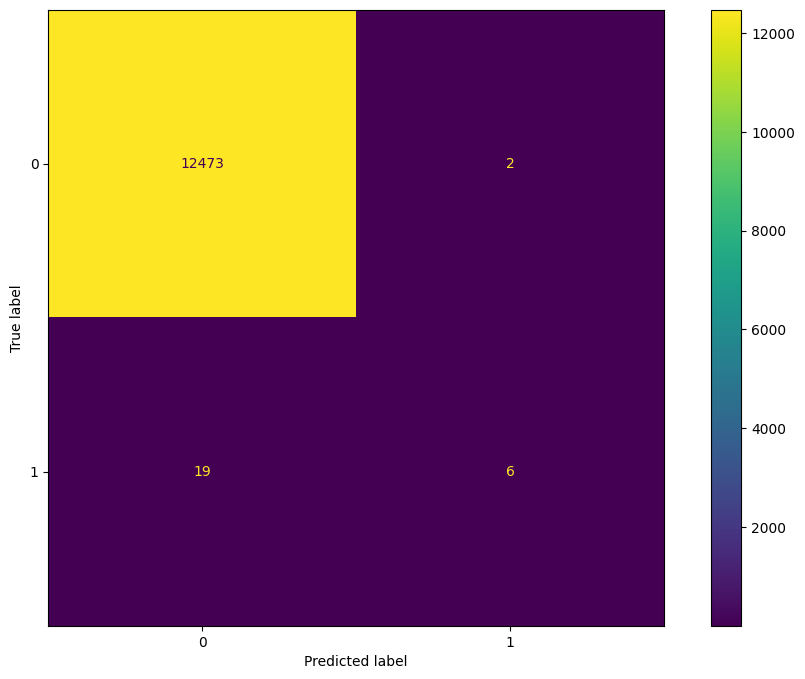

In [68]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Do lado esquerdo, os valores marcados com zero seriam os nossos verdadeiros negativos, são as partes que não são fraudes e estão acertando muito, porém, o verdadeiro positivo acertou apenas uma vez. Algo diferente, portanto, está contecendo: ele está acertando muito em uma classe e pouco em outra. Os outros valores estão bem baixos. Podemos arriscar  que as classes estão um pouco desbalanceadas, a classe majoritária era a classe de mais valores que não são fraude, mas também podemos avaliar o nosso modelo com outra métrica que a Curva Roc.

Com a Curva Roc se trata de uma curva que se aproxima do valor 1. Ela trará outra métrica junto que é a AUC (Are Under the Curve)

**Curva ROC**

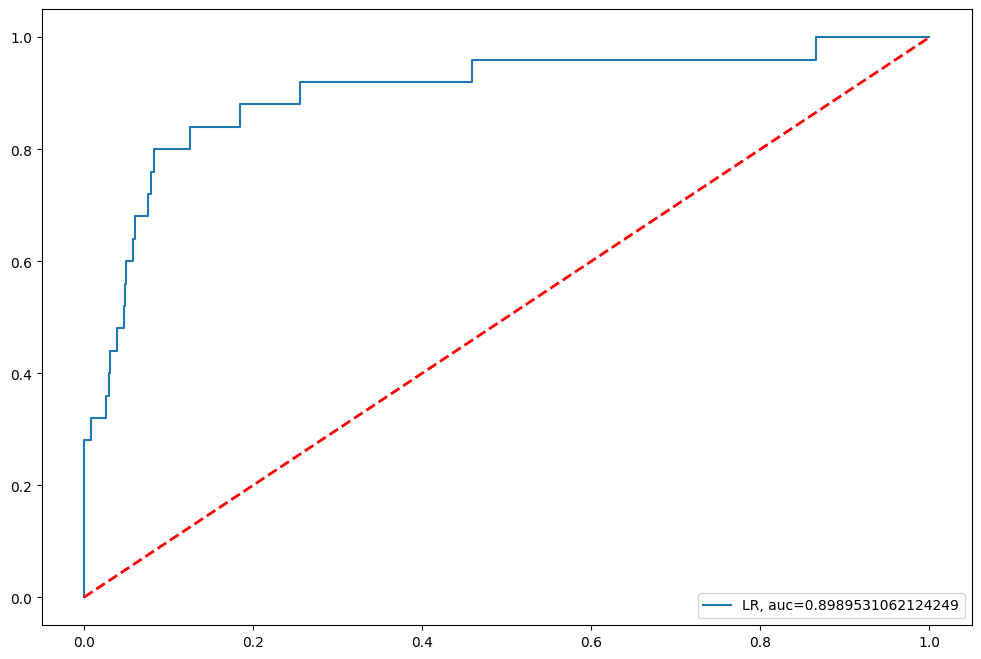

In [69]:
y_pred_proba = lr.predict_proba(X_test)[::, 1]
fpr, tpr, _= metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr,tpr,label="LR, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)


# Balanceamento

Percebe-se que a linha representando o classificador Regressão Logística, com o nome de data 1, cresce de uma forma relativamente rápida até atingir o valor máximo da taxa de verdadeiros positivos (o recall). Isso significa que o modelo atinge 100% de classificação correta dos positivos em aproximadamente (0.2, 1) e permanece até atingir o ponto (1, 1) do gráfico.

Esse ponto no gráfico nos diz que o modelo tem 100% de taxa de verdadeiros positivos e 100% de taxa de falso negativos. Isso demonstra que o modelo classifica todas as amostras positivas corretamente e que todas as que não são positivas foram incorretamente classificadas. Então, quando o modelo chega em 100% de taxa de verdadeiros positivos e lá permanece até atingir 100% da taxa de falsos positivos, significa que o modelo consegue classificar todas as amostras positivas de forma correta, independentemente do threshold adotado


Foi necessário fazer um  **oversampling**, que é basicamente duplicar, fazer a cópia dos nossos dados da classe minoritária até chegar no valor da classe majoritária. Então, ela faria cópia dos dados de fraude, ou seja, criaria novos dados até chegarmos ao número de dados de não fraude.

In [70]:
SEED=42
smote = SMOTE(random_state=42)

X = df.drop('fraude', axis=1)
y = df['fraude']
X_resampled, y_resampled = smote.fit_resample(X,y)

df_balanced = pd.concat([y_resampled, X_resampled], axis=1)

df_balanced.groupby('fraude').tempo.count()  # Fazer o distinct do campo fralde  balanceado


fraude
0    49900
1    49900
Name: tempo, dtype: int64

In [71]:
X = df_balanced.iloc[:, 1:].values
y = df_balanced.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = SEED)

lr = LogisticRegression(max_iter=1000, random_state=SEED)

lr.fit(X_train, y_train)
y_pred =lr.predict(X_test)

print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.9393587174348698
Precisão: 0.9164115125535823
Recall: 0.9660292100379246
F1: 0.9405664453784813


**Matriz de Confusão**

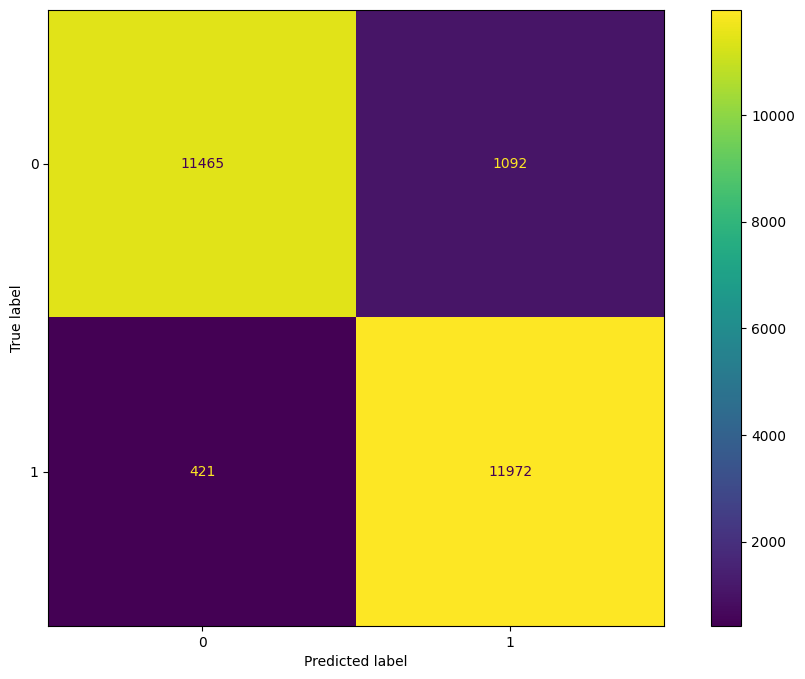

In [72]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

**Curva ROC**

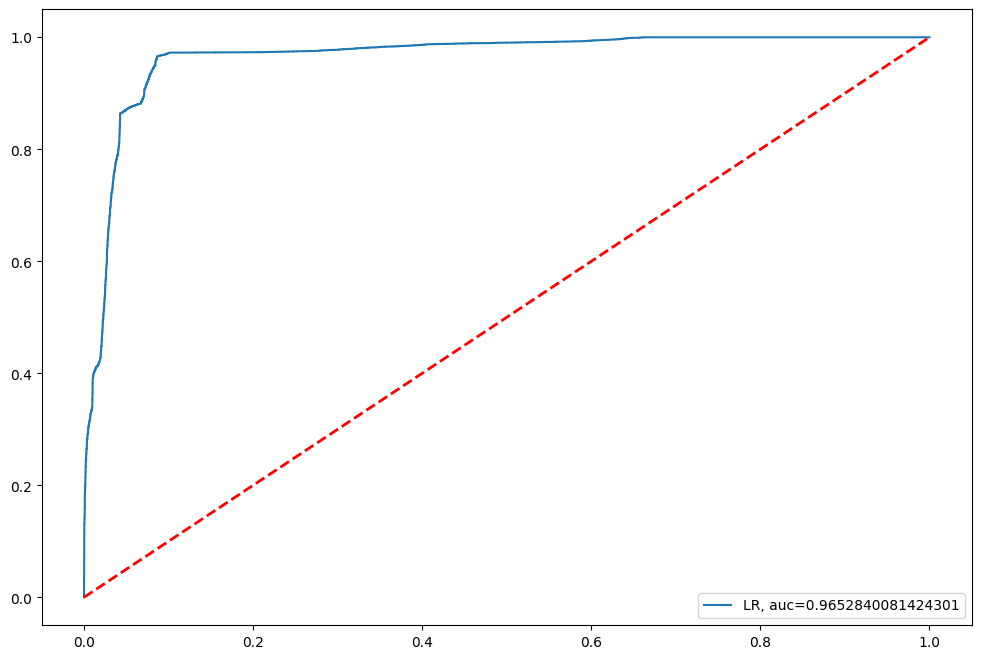

In [73]:
y_pred_proba = lr.predict_proba(X_test)[::, 1]
fpr, tpr, _= metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr,tpr,label="LR, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)


ANALISE ProfileReport


In [74]:
pandas_profiling.ProfileReport(df_balanced)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Analisando os Dados

Com base na as informações obtidas na Matrizes de Correlação extraídas pelo Profile Report,

Fraude está altamente correlacionada com tempo e o "tempo está altamente correlacionado com a fraude.

CASH_IN altamente correlacionado com a fraude.
PAYMENT altamente correlacionado com a fraude.
TRANSFER altamente correlacionado com a fraude.

Já temos em mente que essas quatro variáveis são altamente correlacionadas com o que precisamos. Mais acima na tabela existe mais uma, "saldo_destino" está altamente correlacionada com fraude". Significa que o novo saldo da origem  também está altamente correlacionado com a fraude, porque quando se tira o dinheiro, ele saberá que o valor foi retirado e aparecerá alguma consequência desses valores retirados.

Tempo e fraude também estão altamente correlacionados. O tempo está com uma cor vermelha extremamente forte em relação à fraude. Pode ser que o nosso cliente tenha um padrão de horário para fazer as suas transações. A fraude pode
acontecer em um horário contrário.

Pelas hipóteses encontradas  permitem seguir a diante, levando-as para outras pessoas, como chefe ou clientes


## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

LR: 0.939132 (0.002560)
KNN: 0.987442 (0.001485)
CART: 0.997849 (0.000370)
NB: 0.610701 (0.003899)
SVM: 0.784155 (0.003872)
Bagging: 0.998303 (0.000507)
RF: 0.999132 (0.000334)
ET: 0.999198 (0.000343)
Ada: 0.989993 (0.000846)
GB: 0.992184 (0.001052)
Voting: 0.954549 (0.001864)


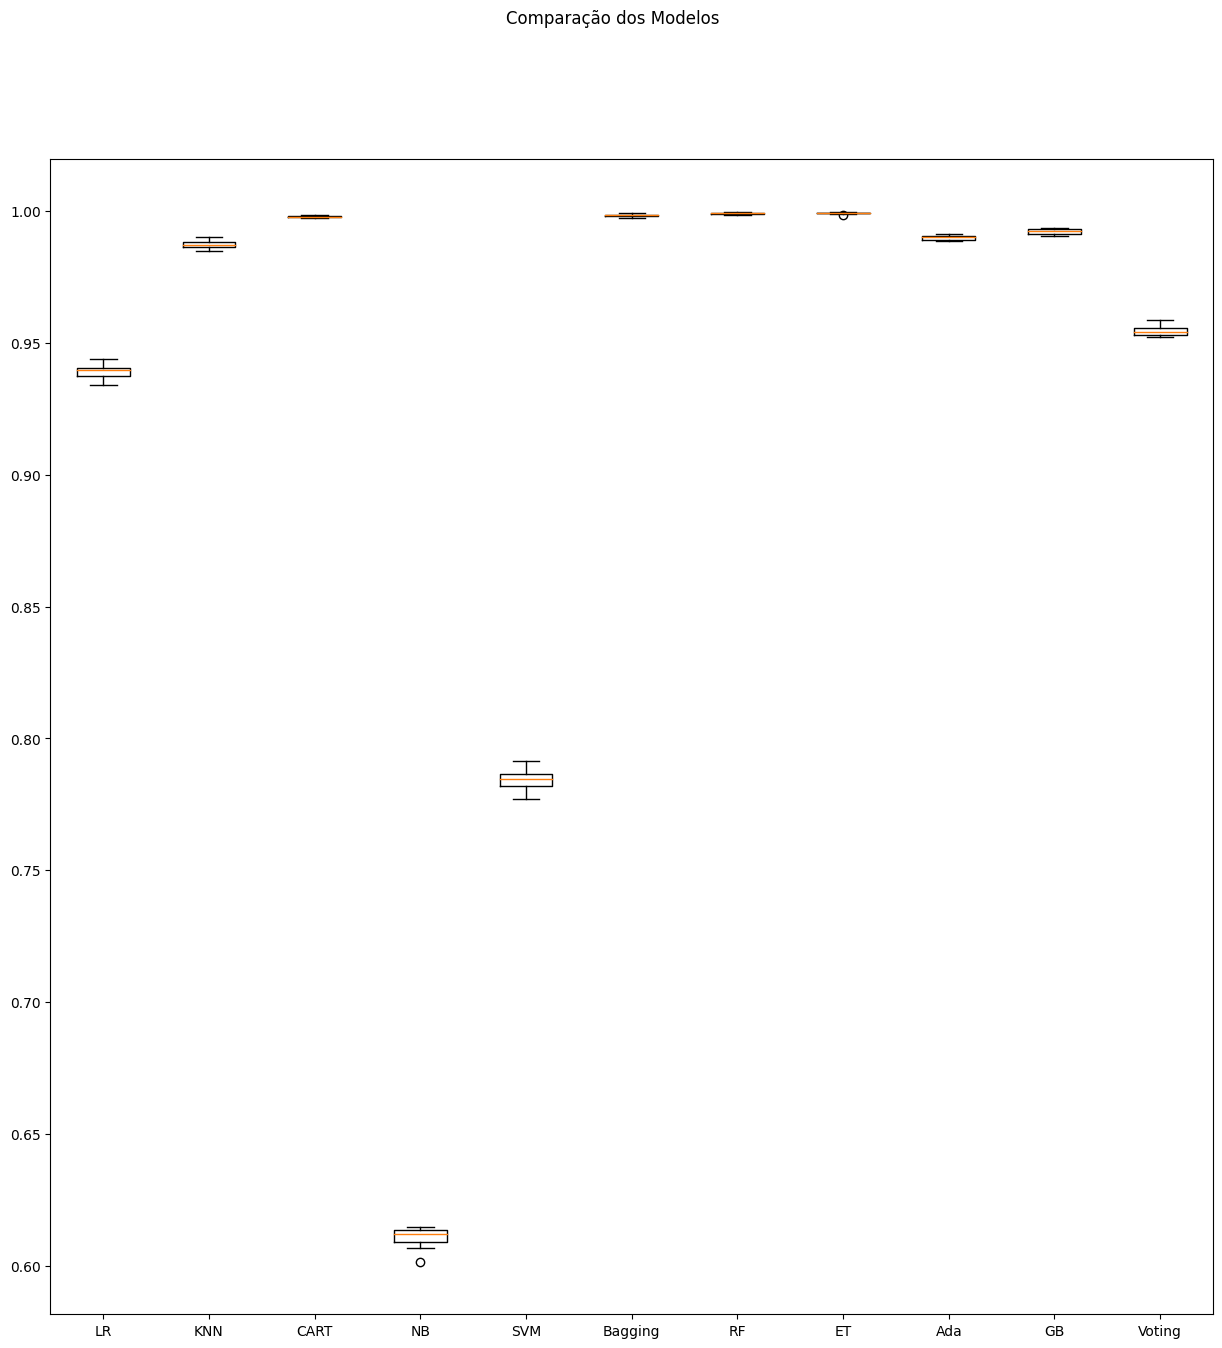

In [75]:
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,15))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Padronização e Normalização

In [ ]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

LR-orig: 0.939 (0.003)
KNN-orig: 0.987 (0.001)
CART-orig: 0.998 (0.000)
NB-orig: 0.611 (0.004)
SVM-orig: 0.784 (0.004)
Bag-orig: 0.998 (0.001)
RF-orig: 0.999 (0.000)
ET-orig: 0.999 (0.000)
Ada-orig: 0.990 (0.001)
GB-orig: 0.992 (0.001)


Avaliação dos valores mais expressivos após a normalização  foram  **o RandonForest e o Extra Tree** .

Abaixo a avaliação do melhor Algorírimo :

**Metricas com Extra Tree**

In [77]:
# Verificação das Métricas na Extra Tree

dt =  DecisionTreeClassifier(max_depth = 5, random_state=7)
model = dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
model = dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("EXtraTree")
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))


EXtraTree
Acurácia: 0.9590380761523046
Precisão: 0.9820262823230183
Recall: 0.934640522875817
F1: 0.9577476434595666


**Cusva ROC - Extra Tree**

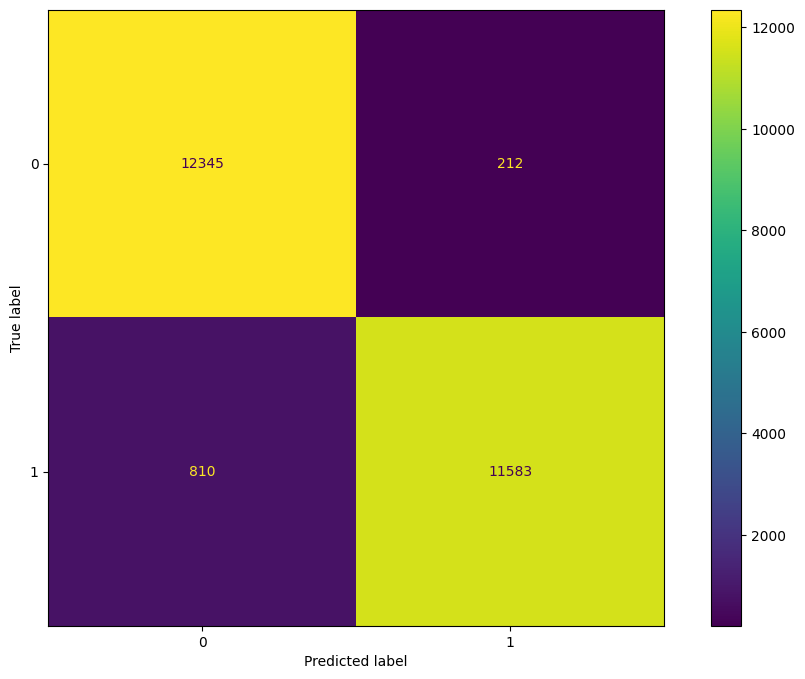

In [78]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Curva ROC Extra Tree

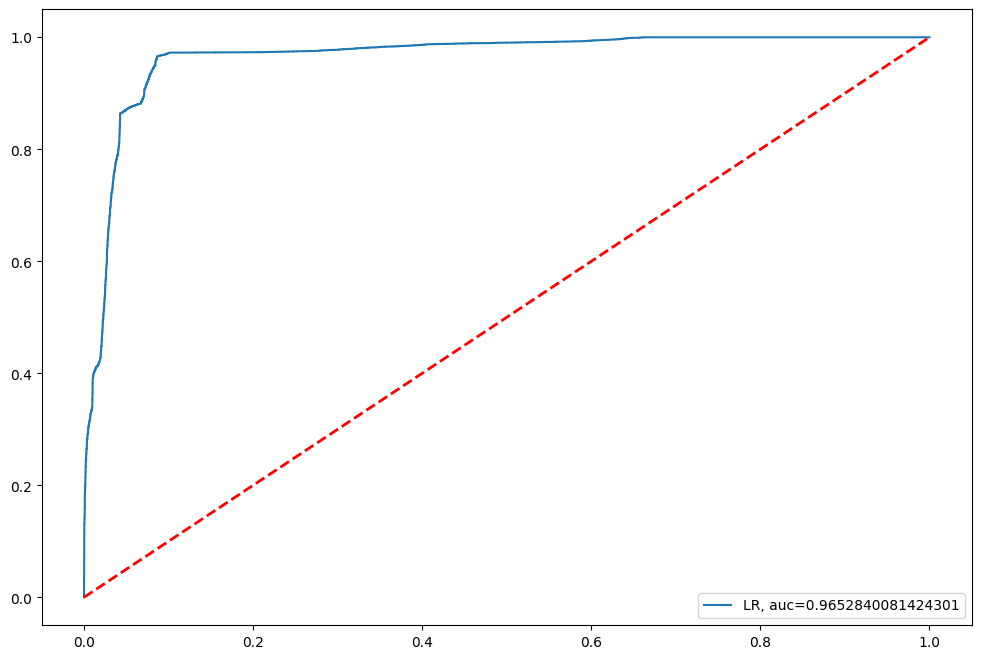

In [79]:
y_pred_proba = lr.predict_proba(X_test)[::, 1]
fpr, tpr, _= metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr,tpr,label="LR, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)


**Metricas Random Forest**

In [80]:
# Verificação das Métricas na Random Forest

rf = RandomForestClassifier(max_depth= 5, random_state = 7)
model = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
model = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Random Forest")
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))


Random Forest
Acurácia: 0.9751102204408818
Precisão: 0.9767536044062854
Recall: 0.9730493020253369
F1: 0.9748979344355068


**Matriz de Confusão Random Forest**

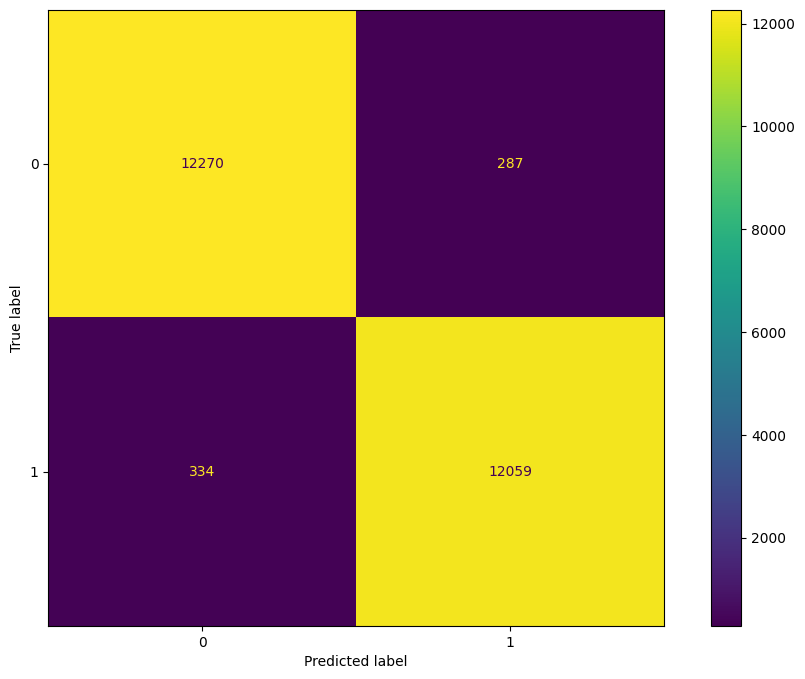

In [81]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

**Curva ROC Ramdom Forest**



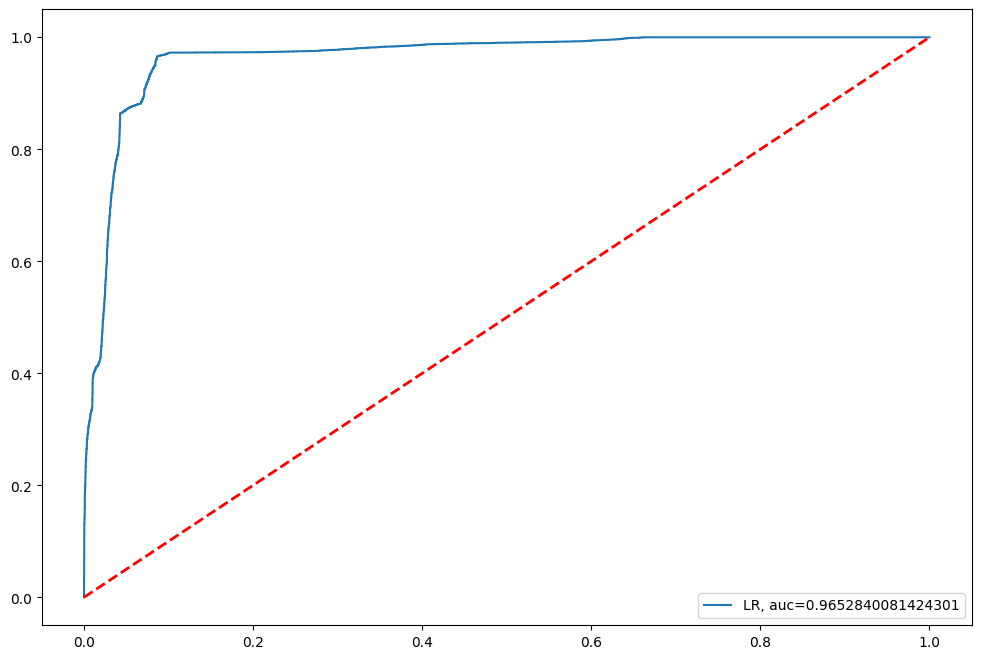

In [82]:
y_pred_proba = lr.predict_proba(X_test)[::, 1]
fpr, tpr, _= metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr,tpr,label="LR, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)


A Randon Forest foi escolhida por apresentar melhor valor de RECALL que é uma métrica mais importante nos casos de Fraude do que a precisão , para evitar retorno de clientes .

Nos Hipermarâmetros foram escolhidos:
O bootstrap , para a verificação tanto na amostras como todo o modelo , mas foi retirado devido a apacecer serpre false nas execuções anteriores.

No Criterion , o gini serve basicamente para medir com qual frequência um elemento é escolhido aleatoriamente e identificado incorretamente, ou seja, quantas vezes ele estaria incorreto a partir da escolha que foi feita.
No caso do entropy, nos fornece um valor médio de quantas perguntas binárias,precisamos fazer para as decisões da árvore para identificarmos a saída da fonte, isto é, até chegarmos em uma folha. Basicamente, quanto maior a entropia, maior o conteúdo da informação que teremos na nossa árvore.
Com  os teste foi verificado que quanto menor o tamanho da base ele escolhe o gini , já a base maior escolhe o entropy , tanto oara original, quanto o modelo normalizado

No max_features que nos oferece três opções: o auto, o sqrt e o log2. O auto e o sqrt pegarão o número máximo de variáveis e aplicarão uma raiz quadrada na quantidade de variáveis de treinamento. Assim, calcularemos o valor de max_features, que são nossas variáveis máximas.

Já o log_2 pegará as variáveis de treinamento e aplicará um log na base 2. Também podemos colocar um número inteiro e um valor numérico, desta maneira, ele não pegará as variáveis de treinamento e colocará, diretamente, o valor inteiro que indicamos

# **Otimização dos hiperparâmetros**

In [83]:
np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
rf= ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('RF-orig', Pipeline(steps=[rf])))
pipelines.append(('RF-padr', Pipeline(steps=[standard_scaler, rf])))
pipelines.append(('RF-norm', Pipeline(steps=[min_max_scaler, rf])))

param_grid = {
    'RF__max_features':  ["auto", "sqrt", "log2"],
#   'RF__bootstrap': [True, False],                # Foi retirado devido a aparecer sempre FALSE no best nas execuções anteriores
    'RF__criterion': ["gini", "entropy"],          # nas tentativas com o dataset pequeno o gini levou vantagem
    'RF__min_samples_leaf': [1, 2, 4]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: RF-orig - Melhor: 0.999198 usando {'RF__criterion': 'entropy', 'RF__max_features': 'auto', 'RF__min_samples_leaf': 1}
Sem tratamento de missings: RF-padr - Melhor: 0.999238 usando {'RF__criterion': 'entropy', 'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 1}
Sem tratamento de missings: RF-norm - Melhor: 0.999265 usando {'RF__criterion': 'entropy', 'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 1}


# **Finalização do Modelo**

In [ ]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
*
model = RandomForestClassifier(n_estimators=num_trees, max_features='auto',min_samples_leaf=1,criterion='entropy')
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

In [ ]:
# Novos dados - não sabemos a classe!
data = {'tempo':             [1,1,1,2,3],
        'valor':             [181,181,181,181,181],
        'saldo_origem':      [181,281,181,0,0],
        'novo_saldo_origem': [181,100,0,0,0],
        'saldo_destino':     [0,0,0,0,0],
        'novo_saldo_destino':[0,0,181,0,0],
        'forma_CASH_IN':     [1,0,0,0,0],
        'forma_CASH_OUT':    [0,1,0,0,0],
        'forma_DEBIT' :      [0,0,1,0,0],
        'forma_PAYMENT' :    [0,0,0,1,0],
        'forma_TRANSFER' :   [0,0,0,0,1]
         }

atributos = ['tempo','valor','saldo_origem','novo_saldo_origem','saldo_destino','novo_saldo_destino','forma_CASH_IN','forma_CASH_OUT','forma_DEBIT','forma_PAYMENT','forma_TRANSFER']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:11].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

Forçado duas práticas de fraude .  O dinheiro sai do saldo do pagador e não aparece no destino .

In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)